Note: this notebook heavily relies on Aleksa Gordic's note book

# Stateful Computations

## Problem

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

In [2]:
# 1) Imputer functions are problematic.

g = 0.  # state

def impure_uses_global(x):
    return x + g

# JAX captures the value of the global/state during the first run
print("First call:", jit(impure_uses_global)(4.))

g = 10.

print("Second call:", jit(impure_uses_global)(5.))

First call: 4.0
Second call: 5.0


In [3]:
# 2) Pattern how JAX's PRNG (not stateful) is handling state.

seed = 0
state = jax.random.PRNGKey(seed)

state1, state2 = jax.random.split(state)

In [4]:
# Problem of state!
# NN love statefulness: model params, optimizer params, BatchNorm, etc.
# and this is a problem with JAX

class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0

    def count(self) -> int:
        self.n += 1
        return self.n

    def reset(self):
        self.n = 0

counter = Counter()

for _ in range(3):
    print(counter.count())


1
2
3


In [5]:
from jax import make_jaxpr

counter.reset()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


In [6]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
    print(fast_count())

1
1
1


## Solution

In [7]:
CounterState = int  # our counter state is implemented as a simple integer

class CounterV2:

    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n + 1, but here we seperate its role as
        # the output and as the counter state for didactic purposes.
        # (as output may be some arbitrary function of state in general case)
        return n+1, n+1

    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
    value, state = counter.count(state)
    print(value)

1
2
3


In [8]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
    value, state = fast_count(state)
    print(value)

1
2
3


In summary, we used the following rule to convert a stateful class:

```python
class StatefulClass
    
    state: State

    def stateful_method(*arg, **kwargs)->Output:
```

into a class of the form:
```python
class StatelessClass

    def stateless_method(state: State, *args, **kwargs)->(Output, State):
```

# Enter PyTree 🌲

Before we start - why are gradients a problem in the first place?

## PyTree basics

In [9]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2    # +175B params more (minus 4)

# JAX: .backward() is not that great
# also JAX:
x, y, z, w = [1.] * 4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)

# Great now we just need to update our params!
# lr = 0.001
# x -= lr * dfdx
# y -= lr * dfdy
# ... (175B lines later)
# w -= lr * dfdw

2.0 2.0 2.0 2.0


We do have a better way!

We want to, more naturally, wrap our params in some more complex data structures like dictionaries, etc.

JAX knows how to deal with these! The answer is called a **PyTree**

In [10]:
pytree_example = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3])
]

for pytree in pytree_example:
    leaves = jax.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leave: {leaves}")

[1, 'a', <object object at 0x7f0192beef90>]   has 3 leave: [1, 'a', <object object at 0x7f0192beef90>]
(1, (2, 3), ())                               has 3 leave: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leave: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leave: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leave: [Array([1, 2, 3], dtype=int32)]


<ipython-input-10-d409974db5ba>:10: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  leaves = jax.tree_leaves(pytree)


In [11]:
# How do we manipulate PyTrees?

list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

# For single arg functions use tree_map
# tree_map iterates through leaves and applies the lambda function
print(jax.tree.map(lambda x: x*2, list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [12]:
another_list_of_lists = list_of_lists
print(jax.tree.map(lambda x, y: x - y, list_of_lists, another_list_of_lists))

[{'a': 0}, [0, 0, 0], [0, 0], [0, 0, 0, 0]]


In [13]:
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append(2)
print(jax.tree.map(lambda x, y: x - y, list_of_lists, another_list_of_lists))

ValueError: List arity mismatch: 5 != 4; list: [{'a': 3}, [1, 2, 3], [1, 2], [1, 2, 3, 4], 2].

## Less contrived example: training a toy MLP (multi-layer perceptron) model

In [14]:
def init_mlp_params(layer_widths):
    params = []

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
            biases=np.ones(shape=(n_out,)),
        ))

    return params

params = init_mlp_params([1, 128, 128, 1])

jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [28]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jnp.dot(x, layer['weights']) + layer['biases']
        x = jax.nn.relu(x)

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)    # MSE loss

lr = 0.0001

@jit    # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with thte same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = jax.grad(loss_fn)(params, x, y)

    # Task: analyze grads and make sure it has the same structure as params

    # SGD update
    return jax.tree.map(
        lambda p, g: p - lr * g, params, grads
    )

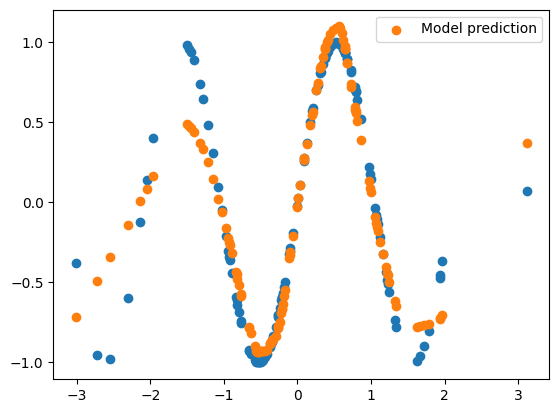

In [29]:
xs = np.random.normal(size=(128, 1))
ys = np.sin(3*xs)  # let's learn how to regress a parabola

# Task experiment a bit with other functions (polynomials, sin, etc.)

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)  # again our lovely pattern

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

## Custom PyTrees

In [30]:
class MyContainer:
    """A named container."""
    def __init__(self, name, a, b, c):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [34]:
example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)]   # 2 MyContainer leaves instead of 8

leaves = jax.tree.leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7f00fde79c90>, <__main__.MyContainer object at 0x7f00fde78040>]
 has 2 leaves:
 [<__main__.MyContainer object at 0x7f00fde79c90>, <__main__.MyContainer object at 0x7f00fde78040>]


In [37]:
try:
    print(jax.tree.map(lambda x: x + 1, example_pytree))    # will not work
except Exception as e:
    print(e)

unsupported operand type(s) for +: 'MyContainer' and 'int'


In [40]:
# Let's get it to work! We'll need to define 2 functions (flatten/unflatten)

def flatten_MyContainer(container):
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node.
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name

    return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

# Register a custom PyTree node
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)

ValueError: Duplicate custom PyTreeDef type registration for <class '__main__.MyContainer'>.

In [41]:
# Let's try again!
leaves = jax.tree.leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7f00fde79c90>, <__main__.MyContainer object at 0x7f00fde78040>]
 has 6 leaves:
 [1, 2, 3, 4, 5, 6]


In [42]:
# Let's try applying tree map again
result = jax.tree.map(lambda x: x + 1, example_pytree)
print(jax.tree.leaves(result))

[2, 3, 4, 5, 6, 7]


In [44]:
# Finally a common gotcha working with PyTrees: mistaking nodes for leaves/children

zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

# Trye to make another tree with ones instead of zeros
shapes = jax.tree.map(lambda x: jnp.array(x.shape), zeros_tree)
print(shapes)

ones_tree = jax.tree.map(jnp.ones, shapes)
print(ones_tree)

# Task: debug this

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]
[Array([2, 3], dtype=int32), Array([3, 4], dtype=int32)]
[Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32), Array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)]


# Parallelism in JAX

parallelism in JAX is handled by another fundamental transform function: `pmap`

## `pmap` basics

In [1]:
# Let's try to get ourselves some TPU goodness
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [4]:
# Let's use a simple running example here
x = np.arange(5)  # signal
w = np.array([2., 3., 4.])  # window/kernel

def convolve(w, x):  # implementation of 1D convolution/correlation
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    return jnp.array(output)

result = convolve(w, x)
print(repr(result))

Array([11., 20., 29.], dtype=float32)


In [5]:
n_devices = jax.local_device_count()
print(f'Number of available devices: {n_devices}')

# Let's now imagine we have a much heavier load (a batch of examples)
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

print(xs.shape, ws.shape)

Number of available devices: 8
(8, 5) (8, 3)


In [6]:
# First way to optimize this is to simply use vmap
vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)


In [7]:
# The amazing thing is if you just swap vmap for pmap you are now running on multiple
# devices. How cool is that?
pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))  # ShardedDeviceArray!

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)


In [8]:
# No cross-device communication costs. Computations are done independently on each dev.
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

Array([[   78.,   138.,   198.],
       [ 1188.,  1383.,  1578.],
       [ 3648.,  3978.,  4308.],
       [ 7458.,  7923.,  8388.],
       [12618., 13218., 13818.],
       [19128., 19863., 20598.],
       [26988., 27858., 28728.],
       [36198., 37203., 38208.]], dtype=float32)


In [9]:
# Same results but we don't have to manually broadcast w (recall: same as for vmap!)
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

Array([[ 11.,  20.,  29.],
       [ 56.,  65.,  74.],
       [101., 110., 119.],
       [146., 155., 164.],
       [191., 200., 209.],
       [236., 245., 254.],
       [281., 290., 299.],
       [326., 335., 344.]], dtype=float32)


This is all great, but oftentimes we do need to communicate between devices. 📱

Let's see how that is handled.

## Communication between devices

In [12]:
# Same example as above but this time we communicate across devices
# in order to normalize the outputs
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)  # same result as before

    return output / jax.lax.psum(output, axis_name='batch_dim')  # this is where communication happens

res_pmap = jax.pmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)

print(repr(res_pmap))
print(repr(res_vmap))

print(f'Verify the output is normalized: {sum(res_pmap[:, 0])}')

Array([[0.00816024, 0.01408451, 0.019437  ],
       [0.04154303, 0.04577465, 0.04959785],
       [0.07492582, 0.07746479, 0.07975871],
       [0.10830861, 0.10915492, 0.10991956],
       [0.14169139, 0.14084506, 0.14008042],
       [0.17507419, 0.17253521, 0.17024128],
       [0.20845698, 0.20422535, 0.20040214],
       [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Array([[0.00816024, 0.01408451, 0.019437  ],
       [0.04154303, 0.04577465, 0.04959785],
       [0.07492582, 0.07746479, 0.07975871],
       [0.10830861, 0.10915492, 0.10991956],
       [0.14169139, 0.14084506, 0.14008042],
       [0.17507419, 0.17253521, 0.17024128],
       [0.20845698, 0.20422535, 0.20040214],
       [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Verify the output is normalized: 1.0


Great - before we train yet another ML model (this time on multiple devices) let me show you a couple more useful functions!

In [13]:
# Sometimes aside from grads we also need to return the loss value (for logging, etc.)

def sum_squared_error(x, y):
    return sum((x-y)**2)

x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1

# An efficient way to return both grads and loss value
jax.value_and_grad(sum_squared_error)(x, y)

(Array(0.03999997, dtype=float32),
 Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32))

In [15]:
# And sometimes the loss function needs to return intermediate results

def sum_squared_error_with_aux(x, y):
    return sum((x-y)**2), x-y

jax.grad(sum_squared_error_with_aux, has_aux=True)(x, y)  # has_aux=True

(Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32))